## 사전 훈련된 컨브넷 사용하기
* 작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 사전 훈련된 네트워크를 사용하는 것입니다. 
* 원본 데이터셋이 충분히 크고 일반적이라면 사전 훈련된 네트워크에 의해 학습된 특성의 계층 구조는 실제 세상에 대한 일반적인 모델로 효율적인 역할을 할 수 있습니다. 
* 새로운 문제가 원래 작업과 완전히 다른 클래스에 대한 것이더라도 이런 특성은 많은 컴퓨터 비전 문제에 유용합니다. 
* 학습된 특성을 다른 문제에 적용할 수 있는 이런 유연성은 이전의 많은 얕은 학습 방법과 비교했을 때 딥러닝의 핵심 장점입니다. 이런 방식으로 작은 데이터셋을 가진 문제에도 딥러닝이 효율적으로 작동할 수 있습니다.
* 여기에서는 (1.4백만 개의 레이블된 이미지와 1,000개의 클래스로 이루어진) ImageNet 데이터셋에서 훈련된 대규모 컨브넷을 사용해 보겠습니다. ImageNet 데이터셋은 다양한 종의 강아지와 고양이를 포함해 많은 동물들을 포함하고 있습니다. 그래서 강아지 vs. 고양이 분류 문제에 좋은 성능을 낼 것 같습니다.
* 캐런 시몬연과 앤드류 지서먼이 2014년에 개발한 VGG16 구조를 사용하겠습니다. VGG16은 간단하고 ImageNet 데이터셋에 널리 사용되는 컨브넷 구조입니다. VGG16은 조금 오래되었고 최고 수준의 성능에는 못미치며 최근의 다른 모델보다는 조금 무겁습니다. 
* VGG, ResNet, Inception, Inception-ResNet, Xception 등을 적용 할 수 있습니다.

### 사전 훈련된 네트워크를 사용하는 두 가지 방법
* 특성 추출 : 특성 추출기로 사전 훈련된 모델 이용
* **미세 조정 (Fine Tuning)** : 사전훈련된 모델의 미세 튜닝

## 미세 조정 (Fine Tuning)
* 모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 미세 조정입니다. 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것입니다. 주어진 문제에 조금 더 밀접하게 재사용 모델의 표현을 일부 조정하기 때문에 미세 조정이라고 부릅니다.

### 네트워크 미세 조정 방법
* 기반 네트워크에서 일부 층의 동결을 해제합니다.
* 동결을 해제한 층과 새로 추가한 층을 함께 훈련합니다.

## 데이터 준비

In [0]:
%matplotlib inline

test = 1

In [0]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [28]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
# train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files] # for linux
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files] # for windows
print(train_labels[:3])

['dog', 'dog', 'dog']


In [29]:
validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
# validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files] # for linux
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in validation_files] # for windows

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [0]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

In [16]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

['dog', 'dog', 'dog', 'dog', 'dog'] [1 1 1 1 1]


## VGG16 네트워크 Fine Tuning 영역 설정

In [17]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = tensorflow.keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128

In [18]:
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f50dba245f8>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50dba24be0>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50dcdfb940>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f50dbb43a90>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50dbb43b00>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50dbadd208>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f50dbacb860>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50dbacb898>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50e9509400>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50e9519a58>,block3_conv3,False


In [19]:
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: []


In [20]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: [<tf.Variable 'block4_conv1/kernel:0' shape=(3, 3, 256, 512) dtype=float32>, <tf.Variable 'block4_conv1/bias:0' shape=(512,) dtype=float32>, <tf.Variable 'block4_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32>, <tf.Variable 'block4_conv2/bias:0' shape=(512,) dtype=float32>, <tf.Variable 'block4_conv3/kernel:0' shape=(3, 3, 512, 512) dtype=float32>, <tf.Variable 'block4_conv3/bias:0' shape=(512,) dtype=float32>, <tf.Variable 'block5_conv1/kernel:0' shape=(3, 3, 512, 512) dtype=float32>, <tf.Variable 'block5_conv1/bias:0' shape=(512,) dtype=float32>, <tf.Variable 'block5_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32>, <tf.Variable 'block5_conv2/bias:0' shape=(512,) dtype=float32>, <tf.Variable 'block5_conv3/kernel:0' shape=(3, 3, 512, 512) dtype=float32>, <tf.Variable 'block5_conv3/bias:0' shape=(512,) dtype=float32>]


In [21]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f50dba245f8>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50dba24be0>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50dcdfb940>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f50dbb43a90>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50dbb43b00>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50dbadd208>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f50dbacb860>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50dbacb898>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50e9509400>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f50e9519a58>,block3_conv3,False


## Fine Tuning with Data Augmentation 모델 설계 & 실행

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = _________(train_imgs, train_labels_enc, batch_size=30)
val_generator = _________(validation_imgs, validation_labels_enc, batch_size=20)

In [23]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(________)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 8192)              14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Tra

In [24]:
# colab: 45분 정도 소요됨
history = model.________(_______, steps_per_epoch=100, epochs=100,
                              validation_data=_________, validation_steps=50, verbose=1)

Epoch 1/100
100/100 [==============================] - 31s 308ms/step - loss: 0.6042 - acc: 0.6683 - val_loss: 0.4214 - val_acc: 0.8050
Epoch 2/100
100/100 [==============================] - 19s 190ms/step - loss: 0.4081 - acc: 0.8123 - val_loss: 0.2100 - val_acc: 0.9240
Epoch 3/100
100/100 [==============================] - 19s 194ms/step - loss: 0.3247 - acc: 0.8580 - val_loss: 0.1786 - val_acc: 0.9190
Epoch 4/100
100/100 [==============================] - 19s 194ms/step - loss: 0.2819 - acc: 0.8777 - val_loss: 0.1506 - val_acc: 0.9380
Epoch 5/100
100/100 [==============================] - 20s 199ms/step - loss: 0.2637 - acc: 0.8847 - val_loss: 0.1517 - val_acc: 0.9380
Epoch 6/100
100/100 [==============================] - 20s 197ms/step - loss: 0.2406 - acc: 0.9010 - val_loss: 0.1823 - val_acc: 0.9140
Epoch 7/100
100/100 [==============================] - 20s 197ms/step - loss: 0.2109 - acc: 0.9180 - val_loss: 0.2652 - val_acc: 0.8920
Epoch 8/100
100/100 [===========================

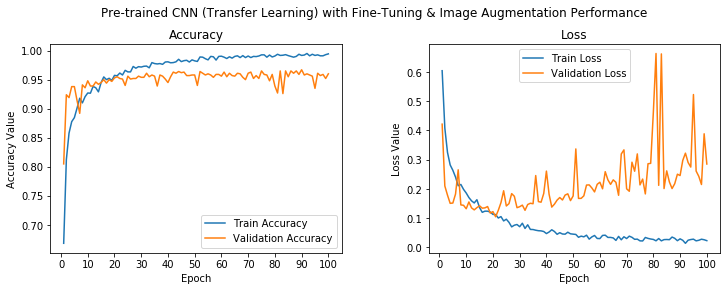

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Fine-Tuning & Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('cats_dogs_tlearn_finetune_img_aug_cnn.h5')